# BADNet 

This Notebook demonstrates how a CNN is capable of Burnt Area Detection.

WIP - Work in Progress - This Notebook is not finished yet and resembles more like a draft.

General idea:

- Feature Input:
  - Sentinel-2 images of bands b8 and b12
  - pictures are pre-fire and post-fire
  - additionally, post-fire clouds and shadows
- Label Input:
  - Burnt Area Mask
- CNN: 
  - 2D CNN with 6 bands as input

CNNs are not able to segmet a label by default. Therefore the CNN is trained to predict the amount of burnt pixels in a given image. The label is the percentage of burnt pixels in the image. The CNN is trained to minimize the mean squared error between the predicted and the true percentage of burnt pixels.

scientific questions:
- CNN input size
- CNN architecture
- exact training procedure

## General Setup

The Model will be created with PyTorch and Lightning to ensure fast training and reproducibility.

In [11]:
# surpress UserWarnings
import warnings
warnings.filterwarnings("ignore")
from importlib_metadata import version
import platform
print('The Python version is {}.'.format(platform.python_version()))

import numpy as np
print('The numpy version is {}.'.format(version('numpy')))

import rasterio
print('The rasterio version is {}.'.format(version('rasterio')))

import torch
print('The torch version is {}.'.format(version('torch')))
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import pytorch_lightning as pl
print('The pytorch_lightning version is {}.'.format(version('pytorch_lightning')))
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

import matplotlib.pyplot as plt
print('The matplotlib version is {}.'.format(version('matplotlib')))

import pandas as pd
print('The pandas version is {}.'.format(version('pandas')))

# additional basic packages
import random
import time

# check the hardware possibilities
pl.Trainer(accelerator="auto", devices="auto", strategy="auto")

# data paths
feature_file_path = 'data/FeatureFile_230628.tif'
label_file_path = 'data/LabelFile_230628.tif'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The Python version is 3.11.5.
The numpy version is 1.26.0.
The rasterio version is 1.3.8.
The torch version is 2.0.1.
The pytorch_lightning version is 2.0.9.
The matplotlib version is 3.8.0.
The pandas version is 2.1.1.


## Input Data and Data Loading

The Sentinel-2 bands are:

1. b8 (reducer median, pre fire)
2. b12 (reducer median, pre fire)
3. b8 (post fire)
4. b12 (post fire)
5. clouds (from CloudSen, post fire)
6. shadows (from CloudSen, post fire)

Data available in GeoTiff in uint16 format.

File: data/FeatureFile_230628.tif
Number of bands: 6
Dimensions: 5010 x 4676
CRS: EPSG:4326
Data type: uint16
Band 1 - Min: 289 Max: 5580
Band 2 - Min: 137 Max: 5070
Band 3 - Min: 1171 Max: 14924
Band 4 - Min: 1121 Max: 16386
Band 5 - Min: 0 Max: 9999
Band 6 - Min: 0 Max: 9999


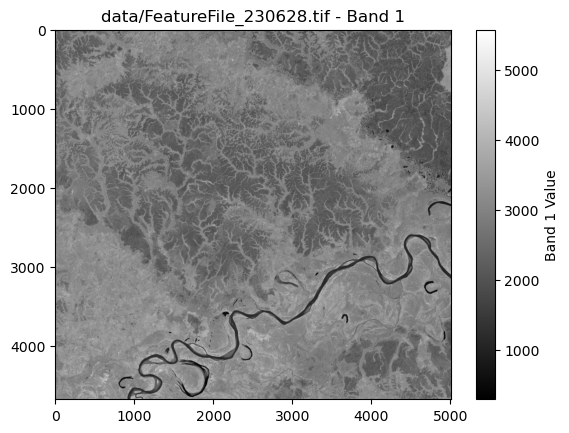

File: data/LabelFile_230628.tif
Number of bands: 1
Dimensions: 5010 x 4676
CRS: EPSG:4326
Data type: uint16
Band 1 - Min: 0 Max: 1


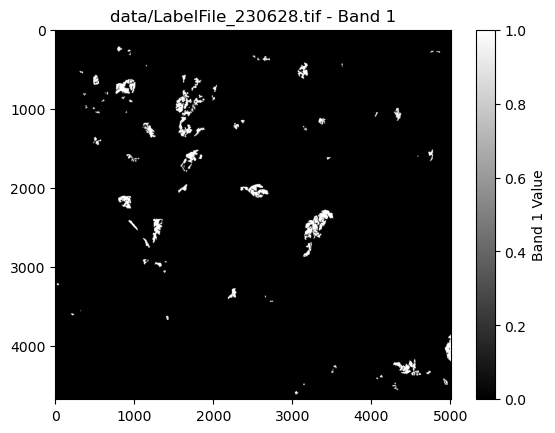

In [12]:
def analyze_geotiff(file_path, band_number=1):
    with rasterio.open(file_path) as file:
        print(f'File: {file_path}')
        print(f'Number of bands: {file.count}')
        print(f'Dimensions: {file.width} x {file.height}')
        print(f'CRS: {file.crs}')
        print(f'Data type: {file.dtypes[0]}')

        # print the min and max for each band
        for i in range(1, file.count + 1):
            band_data = file.read(i)
            print(f'Band {i} - Min: {band_data.min()} Max: {band_data.max()}')
        
        band_data = file.read(1)
        plt.imshow(band_data, cmap='gray')
        plt.colorbar(label=f'Band {band_number} Value')
        plt.title(f'{file_path} - Band {band_number}')
        plt.show()

# Usage:
analyze_geotiff(feature_file_path)
analyze_geotiff(label_file_path)

One of the tricky parts in this dataset is the low amount of positive cases. The amount of burnt pixels is very low compared to the amount of non-burnt pixels. This is why the CNN is trained to predict the percentage of burnt pixels in the image. The label is the percentage of burnt pixels in the image. The CNN is trained to minimize the mean squared error between the predicted and the true percentage of burnt pixels.

Also this is why a weighted loss function is used. The loss function is weighted by the percentage of burnt pixels in the image. This way the CNN is forced to learn the few positive cases.

In [13]:
# sum up all values in the label file
with rasterio.open(label_file_path) as label_file:
    label_data = label_file.read(1)
    print(f'Number of pixels: {label_data.size}')
    print(f'Number of positive cases: {np.count_nonzero(label_data)}')
    print(f'Number of negative cases: {label_data.size - np.count_nonzero(label_data)}')

# amount of burnt pixels with 2 digits after the comma
print(f'Percentage of positive cases: {np.count_nonzero(label_data) / label_data.size * 100:.2f}%')

Number of pixels: 23426760
Number of positive cases: 391166
Number of negative cases: 23035594
Percentage of positive cases: 1.67%


Because of possible memory limitations we will create a custom dataloader which loads everything on demand. Also this ensures a better concentration on the CNN architecture.

Note, that some augmentation is used here. The augmentation is applied to the pre-fire image and then the same augmentation is applied to the post-fire image. This is done to ensure that the pre and post fire images are augmented in the same way. Just flipping is used. This helps to decrease the chance of overfitting.

In [14]:
class BadnetDataset(Dataset):
    def __init__(self, feature_file_path, label_file_path, chip_size=64, overlap=0):
        self.feature_file_path = feature_file_path
        self.label_file_path = label_file_path
        
        # Open the files temporarily just to get the dimensions
        with rasterio.open(self.feature_file_path, mode='r') as feature_file:
            self.width, self.height = feature_file.width, feature_file.height
            self.band_count = feature_file.count
            self.band_boundaries = np.zeros((self.band_count, 2))
            for band_number in range(1, self.band_count + 1):
                band_data = feature_file.read(band_number)
                self.band_boundaries[band_number - 1] = [band_data.min(), band_data.max()]
        
        # Define the chip size, overlap, and padding value
        self.chip_size = chip_size
        self.overlap = overlap
        
        # Calculate the number of chips in each dimension
        self.step_size = self.chip_size - self.overlap
        self.chips_x = (self.width - self.overlap) // self.step_size
        self.chips_y = (self.height - self.overlap) // self.step_size
            
    def __len__(self):
        # Total number of chips in the dataset
        return self.chips_x * self.chips_y
    
    def __getitem__(self, idx):
        # Calculate the chip coordinates based on the index
        chip_y, chip_x = divmod(idx, self.chips_x)
        col = chip_x * self.step_size
        row = chip_y * self.step_size
        
        # Define the window size
        window_size = self.chip_size
        
        # Read a window from each file
        with rasterio.open(self.feature_file_path, mode='r') as feature_file, \
             rasterio.open(self.label_file_path, mode='r') as label_file:
            # Read a window from each file
            feature_window = feature_file.read(window=rasterio.windows.Window(col, row, window_size, window_size))
            label_window = label_file.read(window=rasterio.windows.Window(col, row, window_size, window_size))
        
        # Convert the numpy arrays to a supported data type
        feature_window = feature_window.astype(np.float32)
        label_window = label_window.astype(np.int32)
        
        # scale and normalize the features
        for band_number in range(0, self.band_count):
            feature_window[band_number] = (feature_window[band_number] - self.band_boundaries[band_number][0]) / (self.band_boundaries[band_number][1] - self.band_boundaries[band_number][0])
        
        # Convert the windows to PyTorch tensors
        feature_tensor = torch.tensor(feature_window)
        label_tensor = torch.tensor(label_window)
        
        # apply the transform to the data
        feature_tensor, label_tensor = self.randomflip(feature_tensor, label_tensor)
        
        label_tensor = label_tensor.squeeze(0)  # Remove the channel dimension if it exists
        return feature_tensor, label_tensor
    
    # add function for random flips of the tensors
    def randomflip(self, feature_tensor, label_tensor):
        # Randomly flip the image horizontally
        if random.random() > 0.5:
            feature_tensor = torch.flip(feature_tensor, dims=(1,))
            label_tensor = torch.flip(label_tensor, dims=(1,))
        
        # Randomly flip the image vertically
        if random.random() > 0.5:
            feature_tensor = torch.flip(feature_tensor, dims=(2,))
            label_tensor = torch.flip(label_tensor, dims=(2,))
        
        return feature_tensor, label_tensor
        

This is for testing purposes only:

Number of samples: 19856
Data index: 5456


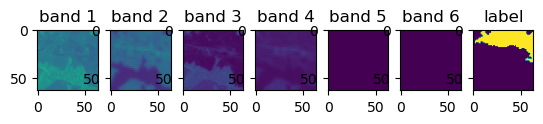

Batch features shape: torch.Size([8, 6, 64, 64])
Batch labels shape: torch.Size([8, 64, 64])
Batch burnt area shape: torch.Size([8, 1])


In [15]:
# Test the dataset access
SanityDataset = BadnetDataset(feature_file_path, label_file_path, chip_size=64, overlap=30)
# print amount of samples
print(f'Number of samples: {len(SanityDataset)}')
#idx = random.randint(0, len(SanityDataset) - 1)
idx=5456 # this is a nice example of a chip with some burnt area
feat, lab = SanityDataset[idx]
print(f'Data index: {idx}')
prob = sum(lab.flatten()) / (lab.shape[0] * lab.shape[1])
# plot all bands
for i in range(0, 6):
    plt.subplot(1, 7, i + 1)
    plt.imshow(feat[i])
    plt.clim(0, 1)
    plt.title(f'band {i + 1}')
plt.subplot(1, 7, 7)
plt.imshow(lab)
plt.title("label")
plt.show()

# test the dataloader which is based on the Dataset for better batching
sanityCheckLoader = DataLoader(SanityDataset, batch_size=8, shuffle=True)
# load a complete batch
batch = next(iter(sanityCheckLoader))
print(f'Batch features shape: {batch[0].shape}')
print(f'Batch labels shape: {batch[1].shape}')
features = batch[0]
labels = batch[1]
bai = labels.sum(dim=(1, 2)) / (labels.shape[1] * labels.shape[2])
bai = bai.unsqueeze(1)  # Add an extra dimension to match the output of your network
print(f'Batch burnt area shape: {bai.shape}')

TODO: this classic torch layout will b e replaced by the LightningDataModule. This will make the code more readable and more maintainable. Also it will be easier to add more datasets.

## CNN Model specifications 

Now it's time to create the ML model. It is a simple CNN with 3 convolutional layers and 2 fully connected layers. The output is a single value between 0 and 1, which is the probability of the area being burned.
Two models are created here:

1. BADNet64 for input sizes of 64x64 pixels
2. BADNet128 for input sizes of 128x128 pixels

Because the label data is between 0 and 1, a sigmoid activation function is used in the last layer.

In [16]:
# Define the CNN model for 6x64x64 images
class BADNet64(nn.Module):
    def __init__(self):
        super(BADNet64, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)  # Output size: 16x64x64
        # Initialize the weights with Xavier initialization maybe?
        #torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output size: 16x32x32
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output size: 32x32x32
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output size: 32x16x16
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output size: 64x16x16
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output size: 64x8x8
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=256)  # Output size: 256
        self.fc2 = nn.Linear(in_features=256, out_features=128)  # Output size: 128
        self.fc3 = nn.Linear(in_features=128, out_features=1)  # Output size: 1
        
        # batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self, x):
        # Apply convolutional layers with ReLU activation, batch normalization and max pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Output size: 16x32x32
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Output size: 32x16x16
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # Output size: 64x8x8
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 8 * 8)  # Output size: 64 * 8 * 8 = 4096
        
        # Apply fully connected layers with ReLU activation and dropout
        x = self.dropout(F.relu(self.fc1(x)))  # Output size: 256
        x = self.dropout(F.relu(self.fc2(x)))  # Output size: 128
        
        # Final layer with sigmoid activation
        x = torch.sigmoid(self.fc3(x))  # Output size: 1
        
        return x

# Sanity check for the model
model = BADNet64()
out = model(torch.rand(1, 6, 64, 64))
assert out.shape == torch.Size([1, 1]), f'Expected output shape of [1, 1] but got {out.shape}'

# Define the CNN model for 6x128x128 images
class BADNet128(nn.Module):
    def __init__(self):
        super(BADNet128, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)  # Output size: 16x128x128
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output size: 16x64x64
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output size: 32x64x64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output size: 32x32x32
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output size: 64x32x32
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output size: 64x16x16
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=256)  # Output size: 256
        self.fc2 = nn.Linear(in_features=256, out_features=128)  # Output size: 128
        self.fc3 = nn.Linear(in_features=128, out_features=1)  # Output size: 1
        
        # batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self, x):
        # Apply convolutional layers with ReLU activation, batch normalization and max pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Output size: 16x32x32
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Output size: 32x16x16
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # Output size: 64x8x8
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 16 * 16)  # Update the flattening step to match the new dimensions
        
        # Apply fully connected layers with ReLU activation and dropout
        x = self.dropout(F.relu(self.fc1(x)))  # Output size: 256
        x = self.dropout(F.relu(self.fc2(x)))  # Output size: 128
        
        # Final layer with sigmoid activation
        x = torch.sigmoid(self.fc3(x))  # Output size: 1
        
        return x

# Sanity check for the model
model = BADNet128()
out = model(torch.rand(1, 6, 128, 128))
assert out.shape == torch.Size([1, 1]), f'Expected output shape of [1, 1] but got {out.shape}'

Before we can start the lightning module, it is necessary to create a custom loss function because the data is very imbalance. The area burned is only a small fraction of the whole image. Therefore we will use a weighted MSE loss function. The loss function is weighted by the percentage of burnt pixels in the image. This way the CNN is forced to learn the few positive cases.

In [17]:
# Weighted MSE loss function
class WeightedMSELoss(nn.Module):
    def __init__(self, positive_weight):
        super().__init__()
        self.positive_weight = positive_weight

    def forward(self, predictions, targets):
        # Calculate the individual squared errors
        squared_errors = (predictions - targets)**2
        
        # Create a tensor of weights based on the targets
        weights = torch.ones_like(targets)
        weights[targets > 0] = self.positive_weight  # Assume target values of 0 indicate negative labels
        
        # Apply the weights to the squared errors
        weighted_squared_errors = weights * squared_errors
        
        # Calculate the mean weighted squared error
        loss = weighted_squared_errors.mean()
        
        return loss

## Training

The training is done with PyTorch Lightning. This ensures fast training and reproducibility.

Create the Lightning module for training and validation. The weight of the MSE loss function is set to 10. This is a hyperparameter which can be tuned.

In [18]:
class LitModel(pl.LightningModule):
    def __init__(self, model = BADNet128(), accuracythreshold = 0.03,  criterion = nn.MSELoss(), optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.accuracythreshold = accuracythreshold
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        loss = self.criterion(outputs, self.burntarearatio(labels))
        self.log('train_loss', loss, on_step=True, on_epoch=True)  # Log average loss over steps and epoch
        return loss

    def validation_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        loss = self.criterion(outputs, self.burntarearatio(labels))
        
        # Accuracy is defined as the percentage of predictions within a certain threshold of the true value
        correct = torch.abs(outputs - self.burntarearatio(labels)) < self.accuracythreshold
        accuracy = correct.float().mean()
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)  # Log average loss over epoch
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True)  # Log average accuracy over epoch
        return loss

    def configure_optimizers(self):
            scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
            return [self.optimizer], [scheduler]
    
    # add function for burnt area ratio
    def burntarearatio(self, labels):
        # Assume labels has shape (batch_size, height, width)
        bai = labels.sum(dim=(1, 2)) / (labels.shape[1] * labels.shape[2])
        return bai.unsqueeze(1)  # Add an extra dimension to match the output of your network

# sanity checking for one batch
litmodel = LitModel(model=BADNet128(), criterion=WeightedMSELoss(positive_weight=10))
SanityDataset = BadnetDataset(feature_file_path, label_file_path, chip_size=128, overlap=0)
sanityCheckLoader = DataLoader(SanityDataset, batch_size=4, shuffle=True)
# Get a single batch of data
train_batch = next(iter(sanityCheckLoader))
val_batch = next(iter(sanityCheckLoader))
# Test the single small batch
train_output = litmodel.training_step(train_batch, batch_idx=0)
val_output = litmodel.validation_step(val_batch, batch_idx=0)

Bring everything together and start the training. The parameters are:

- model: This is the model which ius used
- chip_size: The size of the input images. It must fit the model input size
- overlap: The overlap of the chips. This increases the amount of training data
- accuracythreshold: The threshold for regression. If the error is below this threshold, the prediction is considered as correct
- training_split: The percentage of the data which is used for training
- batch_size: The batch size for training and validation
- epochs: The number of epochs to train
- criterion: The loss function
- optimizer: The optimizer in use

In [19]:
# Tuning Parameters:
model = BADNet128()
chip_size = 128
overlap = 45
accuracythreshold = 0.03
training_split = 0.8
batch_size = 64
epochs = 20
criterion = WeightedMSELoss(positive_weight=20)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)

# Use the mixed precision training if available
torch.set_float32_matmul_precision('medium' if torch.cuda.is_available() else 'high')

# Load the dataset
dataset = BadnetDataset(feature_file_path, label_file_path, chip_size=chip_size, overlap=overlap)
# Split the dataset into training and validation and skip the test set for now
train_size = int(training_split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the trainer
lit_model = LitModel(model=model, criterion=criterion, optimizer=optimizer, accuracythreshold=accuracythreshold)

# This stops training if the validation loss doesn't improve after 8 consecutive epochs
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8)

# This saves the model checkpoints to disk
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', # Monitor validation loss
    dirpath='checkpoints',  # Directory where checkpoints will be saved
    filename='{epoch}',  # The checkpoint filename will include the epoch number
    save_top_k=3,  # Save the top 3 checkpoints
    verbose=True  # Set to True to print information about saved checkpoints
)

# This saves the training and validation metrics to disk
csv_logger = CSVLogger(save_dir='logs', name='badnet_logs')

# Create the trainer
trainer = pl.Trainer( 
    max_epochs=epochs,
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=csv_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finally: start the training process of the model

In [20]:
# Finally: train the model
trainer.fit(lit_model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | BADNet128       | 4.3 M 
1 | criterion | WeightedMSELoss | 0     
----------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.007    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 41/41 [00:17<00:00,  2.28it/s, v_num=11]         

Epoch 0, global step 41: 'val_loss' reached 0.12989 (best 0.12989), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=0-v2.ckpt' as top 3


Epoch 1: 100%|██████████| 41/41 [00:17<00:00,  2.35it/s, v_num=11]

Epoch 1, global step 82: 'val_loss' reached 0.09007 (best 0.09007), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=1-v2.ckpt' as top 3


Epoch 2: 100%|██████████| 41/41 [00:15<00:00,  2.64it/s, v_num=11]

Epoch 2, global step 123: 'val_loss' reached 0.04835 (best 0.04835), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=2-v1.ckpt' as top 3


Epoch 3: 100%|██████████| 41/41 [00:16<00:00,  2.47it/s, v_num=11]

Epoch 3, global step 164: 'val_loss' reached 0.02466 (best 0.02466), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=3-v1.ckpt' as top 3


Epoch 4: 100%|██████████| 41/41 [00:16<00:00,  2.50it/s, v_num=11]

Epoch 4, global step 205: 'val_loss' reached 0.01701 (best 0.01701), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=4.ckpt' as top 3


Epoch 5: 100%|██████████| 41/41 [00:17<00:00,  2.41it/s, v_num=11]

Epoch 5, global step 246: 'val_loss' reached 0.01541 (best 0.01541), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=5.ckpt' as top 3


Epoch 6: 100%|██████████| 41/41 [00:17<00:00,  2.38it/s, v_num=11]

Epoch 6, global step 287: 'val_loss' reached 0.01497 (best 0.01497), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=6.ckpt' as top 3


Epoch 7: 100%|██████████| 41/41 [00:20<00:00,  2.02it/s, v_num=11]

Epoch 7, global step 328: 'val_loss' reached 0.01281 (best 0.01281), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=7.ckpt' as top 3


Epoch 8: 100%|██████████| 41/41 [00:19<00:00,  2.06it/s, v_num=11]

Epoch 8, global step 369: 'val_loss' reached 0.01360 (best 0.01281), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=8.ckpt' as top 3


Epoch 9: 100%|██████████| 41/41 [00:17<00:00,  2.34it/s, v_num=11]

Epoch 9, global step 410: 'val_loss' reached 0.01398 (best 0.01281), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=9.ckpt' as top 3


Epoch 10: 100%|██████████| 41/41 [00:17<00:00,  2.39it/s, v_num=11]

Epoch 10, global step 451: 'val_loss' reached 0.01296 (best 0.01281), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=10-v1.ckpt' as top 3


Epoch 11: 100%|██████████| 41/41 [00:22<00:00,  1.86it/s, v_num=11]

Epoch 11, global step 492: 'val_loss' reached 0.01244 (best 0.01244), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=11.ckpt' as top 3


Epoch 12: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s, v_num=11]

Epoch 12, global step 533: 'val_loss' reached 0.01196 (best 0.01196), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=12.ckpt' as top 3


Epoch 13: 100%|██████████| 41/41 [00:23<00:00,  1.74it/s, v_num=11]

Epoch 13, global step 574: 'val_loss' reached 0.01257 (best 0.01196), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=13-v1.ckpt' as top 3


Epoch 14: 100%|██████████| 41/41 [00:23<00:00,  1.78it/s, v_num=11]

Epoch 14, global step 615: 'val_loss' was not in top 3


Epoch 15: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, v_num=11]

Epoch 15, global step 656: 'val_loss' was not in top 3


Epoch 16: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s, v_num=11]

Epoch 16, global step 697: 'val_loss' reached 0.01253 (best 0.01196), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=16.ckpt' as top 3


Epoch 17: 100%|██████████| 41/41 [00:24<00:00,  1.66it/s, v_num=11]

Epoch 17, global step 738: 'val_loss' reached 0.01232 (best 0.01196), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=17-v2.ckpt' as top 3


Epoch 18: 100%|██████████| 41/41 [00:32<00:00,  1.28it/s, v_num=11]

Epoch 18, global step 779: 'val_loss' reached 0.01139 (best 0.01139), saving model to 'C:\\Users\\marti\\workspace\\BADNet\\checkpoints\\epoch=18.ckpt' as top 3


Epoch 19: 100%|██████████| 41/41 [00:23<00:00,  1.71it/s, v_num=11]

Epoch 19, global step 820: 'val_loss' was not in top 3
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 41/41 [00:23<00:00,  1.71it/s, v_num=11]


## Evaluation

For evaluation, the CSV is read with pandas and the classic metrics are calculated and plotted.

Logger version: 11


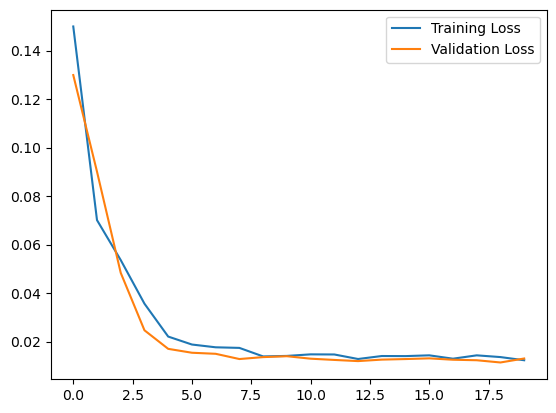

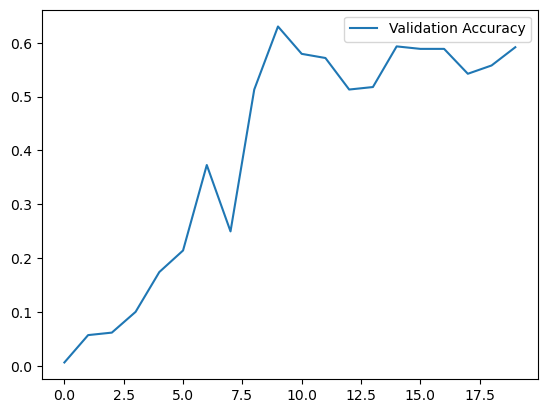

In [21]:
# Load the logged values
log_dir = csv_logger.log_dir
metrics_df = pd.read_csv(f"{log_dir}/metrics.csv")

# The metrics will be in columns named 'train_loss', 'val_loss', and 'val_accuracy'
train_losses = metrics_df['train_loss_epoch'].dropna().values
val_losses = metrics_df['val_loss'].dropna().values
val_accuracies = metrics_df['val_accuracy'].dropna().values

# print the version of the log file
print(f'Logger version: {csv_logger.version}')

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

# plot accuracy
plt.figure()
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()


One random patch is selected as example.

In [22]:
#
feat, lab = val_dataset[random.randint(0, len(val_dataset) - 1)]
prob = sum(lab.flatten()) / (lab.shape[0] * lab.shape[1])
feat = feat.unsqueeze(0)
lab = lab.unsqueeze(0)
target = lit_model.burntarearatio(lab)

# Set the model to evaluation mode
lit_model.eval()
with torch.no_grad():
    output = lit_model(feat)

# Print the output
print(f'Target: {target.item():.2f}')
print(f'Output: {output.item()}')
print(f'Loss: {lit_model.criterion(output, target)}')
print(f'Loss function: {lit_model.criterion}')

Target: 0.00                                                       
Output: 0.024502769112586975
Loss: 0.008534690365195274
Loss function: WeightedMSELoss()
